# PCNA Glimpse generation

This notebook is designed to generate large amount of cropped images of cells with the PCNA-irfp marker for a cluster analysis

In [1]:
import btrack
import matplotlib.pyplot as plt
import os, glob, re
from skimage.io import imread, imsave, imshow
from tqdm import tqdm
import numpy as np
from pathlib import Path
import shutil
from natsort import natsorted
from PIL import Image
import warnings
warnings.filterwarnings('ignore') ###bc imsave throws up low contrast warnings

# Set params

In [2]:
log = []

#expt_root_folder = '/home/nathan/data/confocal/pcna'#
expt_root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi'

#expt = 'MK0000'

channels = '2'#['003'] ### bf 000 gfp 001 rfp 002 irfp 003

#focal_time_range = (0, 800) ### this particular expt stays in focus in this time range

glimpse_size = (64,64)

pos_list = natsorted([pos for pos in os.listdir(expt_root_folder) if 'Pos' in pos]) # natsorted([pos for pos in os.listdir(os.path.join(expt_root_folder, expt)) if 'Pos' in pos])
print(pos_list)

['Position1', 'Position2', 'Position3', 'Position4', 'Position5']


In [5]:
tracks_path

'/home/nathan/data/confocal/pcna/Position5/irfp_tracks_2021_08_09_05_47_51_PM.h5'

In [6]:
for pos in tqdm(pos_list):
    try:
        print('starting', pos)
        tracks_path = glob.glob(os.path.join(expt_root_folder,'{}/irfp*.h5'.format(pos)))[0] #glob.glob(os.path.join(expt_root_folder,'{}/{}/gfp*.h5'.format(expt,pos)))
         

        with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
            tracks = hdf.tracks

        message = str(pos) + 'tracking file loaded'
        log.append(message)
        print(message)

        ### filter tracks that should contain a full cell cycle in (1 timepoint/frame = 4min, cc time approx 200 frames based on quick look)
        tracks = [track for track in tracks if len(track) > 2]#200]

        ### filter tracks that spend a lot of time out of focus
        #tracks = [track for track in tracks if track.t[-1] < focal_time_range[1]]

        ### show number of filtered tracks
        message = str(pos)+'number of glimpses to be generated:'+str(len(tracks))
        log.append(message)
        print(message)

        ### find images and set output
        image_folder = os.path.join(expt_root_folder, pos) #os.path.join(expt_root_folder,expt, pos, pos+'_stacks')
        output_dir = '/home/nathan/data/confocal/pcna/glimpses/non_edge_64px/'#'{}'.format(pos)#'/home/nathan/data/kraken/pcna/glimpses/{}/{}'.format(expt, pos)

        for channel in channels:
            ### load images
            print('Loading image channel', channel)
            images = imread(os.path.join(image_folder, 'Chan{}*.tif'.format(channel)))#imread(os.path.join(image_folder, 'channel{}.tif'.format(channel)))
            print('Image loaded')
            message = str(pos) + 'image loaded'
            log.append(message)

            ### create output directory
            output_ch_dir = output_dir#os.path.join(output_dir, 'channel'+channel)
            Path(output_ch_dir).mkdir(parents=True, exist_ok=True)

            for cell in tqdm(tracks):
                try:
                    message = 'attempting' + str(pos) + 'cell ID' + str(cell.ID)
                    log.append(message)
                    print(message)

                    ### get length of track/glimpse 
                    #length = range(cell.t[0], cell.t[-1])
                    ### get the xy coords of track/glimpse 
                    y, x = cell.x, cell.y #### WHY IS THE COORDINATES TRANSPOSED???? 

                    ### iterate over all frames cropping
                    for j, i in enumerate(cell.t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
                        ### obtain correct frame
                        image = images[i]
                        ### get glimpse dimensions 
                        size = int(glimpse_size[0])
                        ### obtains coordinates of cell and skip if cell drifts over edge
                        x1, y1 = x[j], y[j]
                        if not size < x1 < image.shape[0] - size:
                            continue
                        if not size < y1 < image.shape[0] - size:
                            continue
                        ### obtain coordinates of bounding box of glimpse (centered on cell)
                        #x1, x2, y1, y2 = x[j], x[j]+size, y[j], y[j]+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                        x1, x2, y1, y2 = x[j]-(size/2), x[j]+(size/2), y[j]-(size/2), y[j]+(size/2) #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                        ### pad image incase cell goes off FOV
                        #image = np.pad(image, int(size/2), 'constant', constant_values = 0) 
                        ## glimpse creation by cropping original image
                        glimpse = image[int(x1): int(x2), int(y1): int(y2)]
                        ### fraction of track this frame is at
                        age = round(j/len(cell),3)
                        fn = str(pos)+'_cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
                        ### glimpse output
                        imsave(os.path.join(output_ch_dir, fn), glimpse) 

                    message = str(pos)+'cell ID'+ str(cell.ID) + 'glimpse saved'
                    print(message)
                    log.append(message)

                except:
                    message = str(cell.ID)+ 'failed to produce glimpse'
                    log.append(message)
                    print(message)
    except:
        message = 'something went big wrong on' +str(pos)
        log.append(message)
        print(message)

  0%|          | 0/5 [00:00<?, ?it/s][INFO][2021/08/09 05:56:28 PM] Opening HDF file: /home/nathan/data/confocal/pcna/Position1/irfp_tracks_2021_08_09_05_47_35_PM.h5...
[INFO][2021/08/09 05:56:28 PM] Loading tracks/obj_type_1
[INFO][2021/08/09 05:56:28 PM] Loading objects/obj_type_1 (13218, 5) (13218 filtered: None)
[INFO][2021/08/09 05:56:28 PM] Closing HDF file: /home/nathan/data/confocal/pcna/Position1/irfp_tracks_2021_08_09_05_47_35_PM.h5


starting Position1
Position1tracking file loaded
Position1number of glimpses to be generated:246
Loading image channel 2
Image loaded



  4%|▍         | 11/246 [00:00<00:02, 109.29it/s]

attemptingPosition1cell ID46
Position1cell ID46glimpse saved
attemptingPosition1cell ID32
Position1cell ID32glimpse saved
attemptingPosition1cell ID33
Position1cell ID33glimpse saved
attemptingPosition1cell ID34
Position1cell ID34glimpse saved
attemptingPosition1cell ID35
Position1cell ID35glimpse saved
attemptingPosition1cell ID36
Position1cell ID36glimpse saved
attemptingPosition1cell ID37
Position1cell ID37glimpse saved
attemptingPosition1cell ID38
Position1cell ID38glimpse saved
attemptingPosition1cell ID39
Position1cell ID39glimpse saved
attemptingPosition1cell ID40
Position1cell ID40glimpse saved
attemptingPosition1cell ID41
Position1cell ID41glimpse saved
attemptingPosition1cell ID42
Position1cell ID42glimpse saved
attemptingPosition1cell ID43
Position1cell ID43glimpse saved
attemptingPosition1cell ID44
Position1cell ID44glimpse saved
attemptingPosition1cell ID45
Position1cell ID45glimpse saved
attemptingPosition1cell ID2
Position1cell ID2glimpse saved
attemptingPosition1cell ID


  9%|▉         | 22/246 [00:00<00:05, 42.28it/s] 

Position1cell ID50glimpse saved
attemptingPosition1cell ID51
Position1cell ID51glimpse saved
attemptingPosition1cell ID52
Position1cell ID52glimpse saved
attemptingPosition1cell ID53
Position1cell ID53glimpse saved
attemptingPosition1cell ID54
Position1cell ID54glimpse saved
attemptingPosition1cell ID55
Position1cell ID55glimpse saved
attemptingPosition1cell ID56
Position1cell ID56glimpse saved
attemptingPosition1cell ID57



 15%|█▌        | 37/246 [00:00<00:04, 44.86it/s]

Position1cell ID57glimpse saved
attemptingPosition1cell ID58
Position1cell ID58glimpse saved
attemptingPosition1cell ID59
Position1cell ID59glimpse saved
attemptingPosition1cell ID1
Position1cell ID1glimpse saved
attemptingPosition1cell ID4
Position1cell ID4glimpse saved
attemptingPosition1cell ID31
Position1cell ID31glimpse saved
attemptingPosition1cell ID3
Position1cell ID3glimpse saved
attemptingPosition1cell ID5
Position1cell ID5glimpse saved
attemptingPosition1cell ID6
Position1cell ID6glimpse saved
attemptingPosition1cell ID7
Position1cell ID7glimpse saved
attemptingPosition1cell ID8
Position1cell ID8glimpse saved
attemptingPosition1cell ID9
Position1cell ID9glimpse saved
attemptingPosition1cell ID10
Position1cell ID10glimpse saved
attemptingPosition1cell ID11



 22%|██▏       | 54/246 [00:01<00:03, 56.83it/s]

Position1cell ID11glimpse saved
attemptingPosition1cell ID12
Position1cell ID12glimpse saved
attemptingPosition1cell ID13
Position1cell ID13glimpse saved
attemptingPosition1cell ID14
Position1cell ID14glimpse saved
attemptingPosition1cell ID15
Position1cell ID15glimpse saved
attemptingPosition1cell ID16
Position1cell ID16glimpse saved
attemptingPosition1cell ID18
Position1cell ID18glimpse saved
attemptingPosition1cell ID30
Position1cell ID30glimpse saved
attemptingPosition1cell ID29
Position1cell ID29glimpse saved
attemptingPosition1cell ID28
Position1cell ID28glimpse saved
attemptingPosition1cell ID27
Position1cell ID27glimpse saved
attemptingPosition1cell ID26
Position1cell ID26glimpse saved
attemptingPosition1cell ID25
Position1cell ID25glimpse saved
attemptingPosition1cell ID23
Position1cell ID23glimpse saved
attemptingPosition1cell ID19
Position1cell ID19glimpse saved
attemptingPosition1cell ID20



 25%|██▍       | 61/246 [00:01<00:03, 50.68it/s]

Position1cell ID20glimpse saved
attemptingPosition1cell ID24
Position1cell ID24glimpse saved
attemptingPosition1cell ID22
Position1cell ID22glimpse saved
attemptingPosition1cell ID21
Position1cell ID21glimpse saved
attemptingPosition1cell ID60
Position1cell ID60glimpse saved
attemptingPosition1cell ID61
Position1cell ID61glimpse saved
attemptingPosition1cell ID62
Position1cell ID62glimpse saved
attemptingPosition1cell ID63
Position1cell ID63glimpse saved
attemptingPosition1cell ID64
Position1cell ID64glimpse saved
attemptingPosition1cell ID65
Position1cell ID65glimpse saved
attemptingPosition1cell ID66
Position1cell ID66glimpse saved
attemptingPosition1cell ID67



 30%|██▉       | 73/246 [00:01<00:03, 44.75it/s]

Position1cell ID67glimpse saved
attemptingPosition1cell ID68
Position1cell ID68glimpse saved
attemptingPosition1cell ID69
Position1cell ID69glimpse saved
attemptingPosition1cell ID70
Position1cell ID70glimpse saved
attemptingPosition1cell ID74
Position1cell ID74glimpse saved
attemptingPosition1cell ID73
Position1cell ID73glimpse saved
attemptingPosition1cell ID75
Position1cell ID75glimpse saved
attemptingPosition1cell ID76
Position1cell ID76glimpse saved
attemptingPosition1cell ID77



 34%|███▍      | 84/246 [00:01<00:02, 56.99it/s]

Position1cell ID77glimpse saved
attemptingPosition1cell ID80
Position1cell ID80glimpse saved
attemptingPosition1cell ID81
Position1cell ID81glimpse saved
attemptingPosition1cell ID82
Position1cell ID82glimpse saved
attemptingPosition1cell ID83
Position1cell ID83glimpse saved
attemptingPosition1cell ID84
Position1cell ID84glimpse saved
attemptingPosition1cell ID85
Position1cell ID85glimpse saved
attemptingPosition1cell ID87
Position1cell ID87glimpse saved
attemptingPosition1cell ID86
Position1cell ID86glimpse saved
attemptingPosition1cell ID89
Position1cell ID89glimpse saved
attemptingPosition1cell ID90
Position1cell ID90glimpse saved
attemptingPosition1cell ID91
Position1cell ID91glimpse saved
attemptingPosition1cell ID93
Position1cell ID93glimpse saved
attemptingPosition1cell ID94
Position1cell ID94glimpse saved
attemptingPosition1cell ID97



 37%|███▋      | 91/246 [00:01<00:03, 43.67it/s]

Position1cell ID97glimpse saved
attemptingPosition1cell ID98
Position1cell ID98glimpse saved
attemptingPosition1cell ID99
Position1cell ID99glimpse saved
attemptingPosition1cell ID100
Position1cell ID100glimpse saved
attemptingPosition1cell ID102
Position1cell ID102glimpse saved
attemptingPosition1cell ID103
Position1cell ID103glimpse saved
attemptingPosition1cell ID104
Position1cell ID104glimpse saved
attemptingPosition1cell ID105
Position1cell ID105glimpse saved
attemptingPosition1cell ID106



 43%|████▎     | 107/246 [00:02<00:02, 51.48it/s]

Position1cell ID106glimpse saved
attemptingPosition1cell ID107
Position1cell ID107glimpse saved
attemptingPosition1cell ID108
Position1cell ID108glimpse saved
attemptingPosition1cell ID109
Position1cell ID109glimpse saved
attemptingPosition1cell ID111
Position1cell ID111glimpse saved
attemptingPosition1cell ID112
Position1cell ID112glimpse saved
attemptingPosition1cell ID113
Position1cell ID113glimpse saved
attemptingPosition1cell ID115
Position1cell ID115glimpse saved
attemptingPosition1cell ID117
Position1cell ID117glimpse saved
attemptingPosition1cell ID118
Position1cell ID118glimpse saved
attemptingPosition1cell ID116
Position1cell ID116glimpse saved
attemptingPosition1cell ID119
Position1cell ID119glimpse saved
attemptingPosition1cell ID120
Position1cell ID120glimpse saved
attemptingPosition1cell ID121



 47%|████▋     | 115/246 [00:02<00:02, 52.61it/s]

Position1cell ID121glimpse saved
attemptingPosition1cell ID122
Position1cell ID122glimpse saved
attemptingPosition1cell ID123
Position1cell ID123glimpse saved
attemptingPosition1cell ID124
Position1cell ID124glimpse saved
attemptingPosition1cell ID125
Position1cell ID125glimpse saved
attemptingPosition1cell ID128
Position1cell ID128glimpse saved
attemptingPosition1cell ID129
Position1cell ID129glimpse saved
attemptingPosition1cell ID127
Position1cell ID127glimpse saved
attemptingPosition1cell ID126
Position1cell ID126glimpse saved
attemptingPosition1cell ID130
Position1cell ID130glimpse saved
attemptingPosition1cell ID131
Position1cell ID131glimpse saved
attemptingPosition1cell ID132



 51%|█████     | 126/246 [00:02<00:02, 40.46it/s]

Position1cell ID132glimpse saved
attemptingPosition1cell ID134
Position1cell ID134glimpse saved
attemptingPosition1cell ID136
Position1cell ID136glimpse saved
attemptingPosition1cell ID137
Position1cell ID137glimpse saved
attemptingPosition1cell ID138
Position1cell ID138glimpse saved
attemptingPosition1cell ID140
Position1cell ID140glimpse saved
attemptingPosition1cell ID141
Position1cell ID141glimpse saved
attemptingPosition1cell ID144



 57%|█████▋    | 140/246 [00:02<00:02, 48.99it/s]

Position1cell ID144glimpse saved
attemptingPosition1cell ID143
Position1cell ID143glimpse saved
attemptingPosition1cell ID145
Position1cell ID145glimpse saved
attemptingPosition1cell ID146
Position1cell ID146glimpse saved
attemptingPosition1cell ID147
Position1cell ID147glimpse saved
attemptingPosition1cell ID148
Position1cell ID148glimpse saved
attemptingPosition1cell ID149
Position1cell ID149glimpse saved
attemptingPosition1cell ID150
Position1cell ID150glimpse saved
attemptingPosition1cell ID153
Position1cell ID153glimpse saved
attemptingPosition1cell ID154
Position1cell ID154glimpse saved
attemptingPosition1cell ID155
Position1cell ID155glimpse saved
attemptingPosition1cell ID156
Position1cell ID156glimpse saved
attemptingPosition1cell ID157
Position1cell ID157glimpse saved
attemptingPosition1cell ID158
Position1cell ID158glimpse saved
attemptingPosition1cell ID159
Position1cell ID159glimpse saved
attemptingPosition1cell ID160



 59%|█████▉    | 146/246 [00:03<00:02, 49.23it/s]

Position1cell ID160glimpse saved
attemptingPosition1cell ID161
Position1cell ID161glimpse saved
attemptingPosition1cell ID162
Position1cell ID162glimpse saved
attemptingPosition1cell ID163
Position1cell ID163glimpse saved
attemptingPosition1cell ID164
Position1cell ID164glimpse saved
attemptingPosition1cell ID165
Position1cell ID165glimpse saved
attemptingPosition1cell ID167
Position1cell ID167glimpse saved
attemptingPosition1cell ID168
Position1cell ID168glimpse saved
attemptingPosition1cell ID169
Position1cell ID169glimpse saved
attemptingPosition1cell ID170
Position1cell ID170glimpse saved
attemptingPosition1cell ID171
Position1cell ID171glimpse saved
attemptingPosition1cell ID172
Position1cell ID172glimpse saved
attemptingPosition1cell ID173



 66%|██████▌   | 162/246 [00:03<00:01, 62.04it/s]

Position1cell ID173glimpse saved
attemptingPosition1cell ID174
Position1cell ID174glimpse saved
attemptingPosition1cell ID175
Position1cell ID175glimpse saved
attemptingPosition1cell ID176
Position1cell ID176glimpse saved
attemptingPosition1cell ID177
Position1cell ID177glimpse saved
attemptingPosition1cell ID178
Position1cell ID178glimpse saved
attemptingPosition1cell ID179
Position1cell ID179glimpse saved
attemptingPosition1cell ID180
Position1cell ID180glimpse saved
attemptingPosition1cell ID181
Position1cell ID181glimpse saved
attemptingPosition1cell ID182
Position1cell ID182glimpse saved
attemptingPosition1cell ID183
Position1cell ID183glimpse saved
attemptingPosition1cell ID185
Position1cell ID185glimpse saved
attemptingPosition1cell ID187
Position1cell ID187glimpse saved
attemptingPosition1cell ID188
Position1cell ID188glimpse saved
attemptingPosition1cell ID189
Position1cell ID189glimpse saved
attemptingPosition1cell ID190
Position1cell ID190glimpse saved
attemptingPosition1cel


 74%|███████▍  | 183/246 [00:03<00:00, 78.65it/s]

Position1cell ID191glimpse saved
attemptingPosition1cell ID193
Position1cell ID193glimpse saved
attemptingPosition1cell ID194
Position1cell ID194glimpse saved
attemptingPosition1cell ID195
Position1cell ID195glimpse saved
attemptingPosition1cell ID196
Position1cell ID196glimpse saved
attemptingPosition1cell ID197
Position1cell ID197glimpse saved
attemptingPosition1cell ID198
Position1cell ID198glimpse saved
attemptingPosition1cell ID199
Position1cell ID199glimpse saved
attemptingPosition1cell ID201
Position1cell ID201glimpse saved
attemptingPosition1cell ID202
Position1cell ID202glimpse saved
attemptingPosition1cell ID203
Position1cell ID203glimpse saved
attemptingPosition1cell ID204
Position1cell ID204glimpse saved
attemptingPosition1cell ID205
Position1cell ID205glimpse saved
attemptingPosition1cell ID206
Position1cell ID206glimpse saved
attemptingPosition1cell ID207
Position1cell ID207glimpse saved
attemptingPosition1cell ID208
Position1cell ID208glimpse saved
attemptingPosition1cel


 87%|████████▋ | 213/246 [00:03<00:00, 105.71it/s]

Position1cell ID214glimpse saved
attemptingPosition1cell ID212
Position1cell ID212glimpse saved
attemptingPosition1cell ID213
Position1cell ID213glimpse saved
attemptingPosition1cell ID215
Position1cell ID215glimpse saved
attemptingPosition1cell ID217
Position1cell ID217glimpse saved
attemptingPosition1cell ID218
Position1cell ID218glimpse saved
attemptingPosition1cell ID219
Position1cell ID219glimpse saved
attemptingPosition1cell ID220
Position1cell ID220glimpse saved
attemptingPosition1cell ID221
Position1cell ID221glimpse saved
attemptingPosition1cell ID222
Position1cell ID222glimpse saved
attemptingPosition1cell ID223
Position1cell ID223glimpse saved
attemptingPosition1cell ID224
Position1cell ID224glimpse saved
attemptingPosition1cell ID225
Position1cell ID225glimpse saved
attemptingPosition1cell ID230
Position1cell ID230glimpse saved
attemptingPosition1cell ID231
Position1cell ID231glimpse saved
attemptingPosition1cell ID235
Position1cell ID235glimpse saved
attemptingPosition1cel

 20%|██        | 1/5 [00:04<00:19,  4.90s/it][INFO][2021/08/09 05:56:33 PM] Opening HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5...
[INFO][2021/08/09 05:56:33 PM] Loading tracks/obj_type_1
[INFO][2021/08/09 05:56:33 PM] Loading objects/obj_type_1 (10421, 5) (10421 filtered: None)
[INFO][2021/08/09 05:56:33 PM] Closing HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5


Position1cell ID256glimpse saved
attemptingPosition1cell ID257
Position1cell ID257glimpse saved
attemptingPosition1cell ID259
Position1cell ID259glimpse saved
attemptingPosition1cell ID262
Position1cell ID262glimpse saved
attemptingPosition1cell ID261
Position1cell ID261glimpse saved
attemptingPosition1cell ID264
Position1cell ID264glimpse saved
attemptingPosition1cell ID265
Position1cell ID265glimpse saved
attemptingPosition1cell ID266
Position1cell ID266glimpse saved
attemptingPosition1cell ID267
Position1cell ID267glimpse saved
attemptingPosition1cell ID268
Position1cell ID268glimpse saved
attemptingPosition1cell ID269
Position1cell ID269glimpse saved
attemptingPosition1cell ID270
Position1cell ID270glimpse saved
attemptingPosition1cell ID274
Position1cell ID274glimpse saved
attemptingPosition1cell ID273
Position1cell ID273glimpse saved
attemptingPosition1cell ID271
Position1cell ID271glimpse saved
attemptingPosition1cell ID275
Position1cell ID275glimpse saved
attemptingPosition1cel


  1%|          | 2/206 [00:00<00:12, 16.02it/s]

attemptingPosition2cell ID48
Position2cell ID48glimpse saved
attemptingPosition2cell ID33
Position2cell ID33glimpse saved
attemptingPosition2cell ID34
Position2cell ID34glimpse saved
attemptingPosition2cell ID35
Position2cell ID35glimpse saved
attemptingPosition2cell ID36



  4%|▍         | 8/206 [00:00<00:06, 29.06it/s]

Position2cell ID36glimpse saved
attemptingPosition2cell ID37
Position2cell ID37glimpse saved
attemptingPosition2cell ID38
Position2cell ID38glimpse saved
attemptingPosition2cell ID39
Position2cell ID39glimpse saved
attemptingPosition2cell ID40
Position2cell ID40glimpse saved
attemptingPosition2cell ID41
Position2cell ID41glimpse saved
attemptingPosition2cell ID42
Position2cell ID42glimpse saved
attemptingPosition2cell ID43



  9%|▊         | 18/206 [00:00<00:05, 36.12it/s]

Position2cell ID43glimpse saved
attemptingPosition2cell ID44
Position2cell ID44glimpse saved
attemptingPosition2cell ID45
Position2cell ID45glimpse saved
attemptingPosition2cell ID46
Position2cell ID46glimpse saved
attemptingPosition2cell ID47
Position2cell ID47glimpse saved
attemptingPosition2cell ID2
Position2cell ID2glimpse saved
attemptingPosition2cell ID49
Position2cell ID49glimpse saved
attemptingPosition2cell ID50
Position2cell ID50glimpse saved
attemptingPosition2cell ID51
Position2cell ID51glimpse saved
attemptingPosition2cell ID52



 14%|█▎        | 28/206 [00:00<00:04, 35.82it/s]

Position2cell ID52glimpse saved
attemptingPosition2cell ID53
Position2cell ID53glimpse saved
attemptingPosition2cell ID54
Position2cell ID54glimpse saved
attemptingPosition2cell ID55
Position2cell ID55glimpse saved
attemptingPosition2cell ID56
Position2cell ID56glimpse saved
attemptingPosition2cell ID57
Position2cell ID57glimpse saved
attemptingPosition2cell ID58
Position2cell ID58glimpse saved
attemptingPosition2cell ID59
Position2cell ID59glimpse saved
attemptingPosition2cell ID60
Position2cell ID60glimpse saved
attemptingPosition2cell ID61
Position2cell ID61glimpse saved
attemptingPosition2cell ID62



 18%|█▊        | 38/206 [00:01<00:04, 39.34it/s]

Position2cell ID62glimpse saved
attemptingPosition2cell ID9
Position2cell ID9glimpse saved
attemptingPosition2cell ID32
Position2cell ID32glimpse saved
attemptingPosition2cell ID4
Position2cell ID4glimpse saved
attemptingPosition2cell ID5
Position2cell ID5glimpse saved
attemptingPosition2cell ID6
Position2cell ID6glimpse saved
attemptingPosition2cell ID7
Position2cell ID7glimpse saved
attemptingPosition2cell ID8
Position2cell ID8glimpse saved
attemptingPosition2cell ID10



 22%|██▏       | 46/206 [00:01<00:03, 45.69it/s]

Position2cell ID10glimpse saved
attemptingPosition2cell ID11
Position2cell ID11glimpse saved
attemptingPosition2cell ID12
Position2cell ID12glimpse saved
attemptingPosition2cell ID13
Position2cell ID13glimpse saved
attemptingPosition2cell ID14
Position2cell ID14glimpse saved
attemptingPosition2cell ID15
Position2cell ID15glimpse saved
attemptingPosition2cell ID16
Position2cell ID16glimpse saved
attemptingPosition2cell ID18
Position2cell ID18glimpse saved
attemptingPosition2cell ID31
Position2cell ID31glimpse saved
attemptingPosition2cell ID30
Position2cell ID30glimpse saved
attemptingPosition2cell ID29
Position2cell ID29glimpse saved
attemptingPosition2cell ID28
Position2cell ID28glimpse saved
attemptingPosition2cell ID27
Position2cell ID27glimpse saved
attemptingPosition2cell ID25
Position2cell ID25glimpse saved
attemptingPosition2cell ID24
Position2cell ID24glimpse saved
attemptingPosition2cell ID19
Position2cell ID19glimpse saved
attemptingPosition2cell ID22
Position2cell ID22glimps


 36%|███▌      | 74/206 [00:01<00:01, 81.55it/s]

Position2cell ID66glimpse saved
attemptingPosition2cell ID70
Position2cell ID70glimpse saved
attemptingPosition2cell ID69
Position2cell ID69glimpse saved
attemptingPosition2cell ID71
Position2cell ID71glimpse saved
attemptingPosition2cell ID73
Position2cell ID73glimpse saved
attemptingPosition2cell ID77
Position2cell ID77glimpse saved
attemptingPosition2cell ID79
Position2cell ID79glimpse saved
attemptingPosition2cell ID80
Position2cell ID80glimpse saved
attemptingPosition2cell ID81
Position2cell ID81glimpse saved
attemptingPosition2cell ID83
Position2cell ID83glimpse saved
attemptingPosition2cell ID82
Position2cell ID82glimpse saved
attemptingPosition2cell ID84
Position2cell ID84glimpse saved
attemptingPosition2cell ID85
Position2cell ID85glimpse saved
attemptingPosition2cell ID86
Position2cell ID86glimpse saved
attemptingPosition2cell ID87
Position2cell ID87glimpse saved
attemptingPosition2cell ID89
Position2cell ID89glimpse saved
attemptingPosition2cell ID90
Position2cell ID90glimps


 40%|████      | 83/206 [00:01<00:01, 69.43it/s]

Position2cell ID102glimpse saved
attemptingPosition2cell ID104
Position2cell ID104glimpse saved
attemptingPosition2cell ID106
Position2cell ID106glimpse saved
attemptingPosition2cell ID107
Position2cell ID107glimpse saved
attemptingPosition2cell ID108
Position2cell ID108glimpse saved
attemptingPosition2cell ID110
Position2cell ID110glimpse saved
attemptingPosition2cell ID111
Position2cell ID111glimpse saved
attemptingPosition2cell ID113
Position2cell ID113glimpse saved
attemptingPosition2cell ID115
Position2cell ID115glimpse saved
attemptingPosition2cell ID116
Position2cell ID116glimpse saved
attemptingPosition2cell ID118



 48%|████▊     | 98/206 [00:01<00:01, 57.31it/s]

Position2cell ID118glimpse saved
attemptingPosition2cell ID119
Position2cell ID119glimpse saved
attemptingPosition2cell ID120
Position2cell ID120glimpse saved
attemptingPosition2cell ID121
Position2cell ID121glimpse saved
attemptingPosition2cell ID122
Position2cell ID122glimpse saved
attemptingPosition2cell ID124
Position2cell ID124glimpse saved
attemptingPosition2cell ID126
Position2cell ID126glimpse saved
attemptingPosition2cell ID127
Position2cell ID127glimpse saved
attemptingPosition2cell ID128
Position2cell ID128glimpse saved
attemptingPosition2cell ID129
Position2cell ID129glimpse saved
attemptingPosition2cell ID130
Position2cell ID130glimpse saved
attemptingPosition2cell ID132
Position2cell ID132glimpse saved
attemptingPosition2cell ID134



 51%|█████     | 105/206 [00:02<00:01, 58.95it/s]

Position2cell ID134glimpse saved
attemptingPosition2cell ID135
Position2cell ID135glimpse saved
attemptingPosition2cell ID140
Position2cell ID140glimpse saved
attemptingPosition2cell ID139
Position2cell ID139glimpse saved
attemptingPosition2cell ID137
Position2cell ID137glimpse saved
attemptingPosition2cell ID138
Position2cell ID138glimpse saved
attemptingPosition2cell ID143
Position2cell ID143glimpse saved
attemptingPosition2cell ID142
Position2cell ID142glimpse saved
attemptingPosition2cell ID144
Position2cell ID144glimpse saved
attemptingPosition2cell ID146



 59%|█████▉    | 122/206 [00:02<00:01, 52.84it/s]

Position2cell ID146glimpse saved
attemptingPosition2cell ID147
Position2cell ID147glimpse saved
attemptingPosition2cell ID148
Position2cell ID148glimpse saved
attemptingPosition2cell ID149
Position2cell ID149glimpse saved
attemptingPosition2cell ID150
Position2cell ID150glimpse saved
attemptingPosition2cell ID152
Position2cell ID152glimpse saved
attemptingPosition2cell ID155
Position2cell ID155glimpse saved
attemptingPosition2cell ID156
Position2cell ID156glimpse saved
attemptingPosition2cell ID157
Position2cell ID157glimpse saved
attemptingPosition2cell ID158
Position2cell ID158glimpse saved
attemptingPosition2cell ID159
Position2cell ID159glimpse saved
attemptingPosition2cell ID160
Position2cell ID160glimpse saved
attemptingPosition2cell ID162
Position2cell ID162glimpse saved
attemptingPosition2cell ID163



 62%|██████▏   | 128/206 [00:02<00:01, 44.68it/s]

Position2cell ID163glimpse saved
attemptingPosition2cell ID164
Position2cell ID164glimpse saved
attemptingPosition2cell ID166
Position2cell ID166glimpse saved
attemptingPosition2cell ID168
Position2cell ID168glimpse saved
attemptingPosition2cell ID170
Position2cell ID170glimpse saved
attemptingPosition2cell ID174
Position2cell ID174glimpse saved
attemptingPosition2cell ID173



 74%|███████▍  | 152/206 [00:02<00:00, 72.36it/s]

Position2cell ID173glimpse saved
attemptingPosition2cell ID172
Position2cell ID172glimpse saved
attemptingPosition2cell ID175
Position2cell ID175glimpse saved
attemptingPosition2cell ID178
Position2cell ID178glimpse saved
attemptingPosition2cell ID180
Position2cell ID180glimpse saved
attemptingPosition2cell ID185
Position2cell ID185glimpse saved
attemptingPosition2cell ID182
Position2cell ID182glimpse saved
attemptingPosition2cell ID186
Position2cell ID186glimpse saved
attemptingPosition2cell ID188
Position2cell ID188glimpse saved
attemptingPosition2cell ID189
Position2cell ID189glimpse saved
attemptingPosition2cell ID191
Position2cell ID191glimpse saved
attemptingPosition2cell ID194
Position2cell ID194glimpse saved
attemptingPosition2cell ID193
Position2cell ID193glimpse saved
attemptingPosition2cell ID192
Position2cell ID192glimpse saved
attemptingPosition2cell ID195
Position2cell ID195glimpse saved
attemptingPosition2cell ID196
Position2cell ID196glimpse saved
attemptingPosition2cel


 40%|████      | 2/5 [00:08<00:12,  4.22s/it][INFO][2021/08/09 05:56:37 PM] Opening HDF file: /home/nathan/data/confocal/pcna/Position3/irfp_tracks_2021_08_09_05_47_44_PM.h5...
[INFO][2021/08/09 05:56:37 PM] Loading tracks/obj_type_1
[INFO][2021/08/09 05:56:37 PM] Loading objects/obj_type_1 (11822, 5) (11822 filtered: None)


Position2cell ID226glimpse saved
attemptingPosition2cell ID227
Position2cell ID227glimpse saved
attemptingPosition2cell ID228
Position2cell ID228glimpse saved
attemptingPosition2cell ID229
Position2cell ID229glimpse saved
attemptingPosition2cell ID230
Position2cell ID230glimpse saved
attemptingPosition2cell ID231
Position2cell ID231glimpse saved
attemptingPosition2cell ID232
Position2cell ID232glimpse saved
attemptingPosition2cell ID233
Position2cell ID233glimpse saved
attemptingPosition2cell ID235
Position2cell ID235glimpse saved
attemptingPosition2cell ID239
Position2cell ID239glimpse saved
attemptingPosition2cell ID238
Position2cell ID238glimpse saved
attemptingPosition2cell ID236
Position2cell ID236glimpse saved
attemptingPosition2cell ID237
Position2cell ID237glimpse saved
attemptingPosition2cell ID240
Position2cell ID240glimpse saved
attemptingPosition2cell ID241
Position2cell ID241glimpse saved
attemptingPosition2cell ID242
Position2cell ID242glimpse saved
attemptingPosition2cel

[INFO][2021/08/09 05:56:37 PM] Closing HDF file: /home/nathan/data/confocal/pcna/Position3/irfp_tracks_2021_08_09_05_47_44_PM.h5


Position3tracking file loaded
Position3number of glimpses to be generated:261
Loading image channel 2
Image loaded



  3%|▎         | 7/261 [00:00<00:04, 53.98it/s]

attemptingPosition3cell ID42
Position3cell ID42glimpse saved
attemptingPosition3cell ID50
Position3cell ID50glimpse saved
attemptingPosition3cell ID49
Position3cell ID49glimpse saved
attemptingPosition3cell ID48
Position3cell ID48glimpse saved
attemptingPosition3cell ID47
Position3cell ID47glimpse saved
attemptingPosition3cell ID46
Position3cell ID46glimpse saved
attemptingPosition3cell ID45
Position3cell ID45glimpse saved
attemptingPosition3cell ID44
Position3cell ID44glimpse saved
attemptingPosition3cell ID43
Position3cell ID43glimpse saved
attemptingPosition3cell ID51
Position3cell ID51glimpse saved
attemptingPosition3cell ID40
Position3cell ID40glimpse saved
attemptingPosition3cell ID39
Position3cell ID39glimpse saved
attemptingPosition3cell ID38
Position3cell ID38glimpse saved
attemptingPosition3cell ID36
Position3cell ID36glimpse saved
attemptingPosition3cell ID35
Position3cell ID35glimpse saved
attemptingPosition3cell ID34
Position3cell ID34glimpse saved
attemptingPosition3cell 


 10%|█         | 27/261 [00:00<00:03, 63.88it/s]

Position3cell ID52glimpse saved
attemptingPosition3cell ID53
Position3cell ID53glimpse saved
attemptingPosition3cell ID54
Position3cell ID54glimpse saved
attemptingPosition3cell ID56
Position3cell ID56glimpse saved
attemptingPosition3cell ID57
Position3cell ID57glimpse saved
attemptingPosition3cell ID58
Position3cell ID58glimpse saved
attemptingPosition3cell ID59
Position3cell ID59glimpse saved
attemptingPosition3cell ID60
Position3cell ID60glimpse saved
attemptingPosition3cell ID61
Position3cell ID61glimpse saved
attemptingPosition3cell ID62
Position3cell ID62glimpse saved
attemptingPosition3cell ID63
Position3cell ID63glimpse saved
attemptingPosition3cell ID64
Position3cell ID64glimpse saved
attemptingPosition3cell ID65
Position3cell ID65glimpse saved
attemptingPosition3cell ID1
Position3cell ID1glimpse saved
attemptingPosition3cell ID9
Position3cell ID9glimpse saved
attemptingPosition3cell ID17
Position3cell ID17glimpse saved
attemptingPosition3cell ID16



 15%|█▌        | 40/261 [00:00<00:05, 40.16it/s]

Position3cell ID16glimpse saved
attemptingPosition3cell ID15
Position3cell ID15glimpse saved
attemptingPosition3cell ID33
Position3cell ID33glimpse saved
attemptingPosition3cell ID12
Position3cell ID12glimpse saved
attemptingPosition3cell ID11
Position3cell ID11glimpse saved
attemptingPosition3cell ID10
Position3cell ID10glimpse saved
attemptingPosition3cell ID14
Position3cell ID14glimpse saved
attemptingPosition3cell ID8



 25%|██▍       | 64/261 [00:01<00:02, 69.22it/s]

Position3cell ID8glimpse saved
attemptingPosition3cell ID7
Position3cell ID7glimpse saved
attemptingPosition3cell ID6
Position3cell ID6glimpse saved
attemptingPosition3cell ID5
Position3cell ID5glimpse saved
attemptingPosition3cell ID4
Position3cell ID4glimpse saved
attemptingPosition3cell ID3
Position3cell ID3glimpse saved
attemptingPosition3cell ID2
Position3cell ID2glimpse saved
attemptingPosition3cell ID29
Position3cell ID29glimpse saved
attemptingPosition3cell ID31
Position3cell ID31glimpse saved
attemptingPosition3cell ID30
Position3cell ID30glimpse saved
attemptingPosition3cell ID18
Position3cell ID18glimpse saved
attemptingPosition3cell ID28
Position3cell ID28glimpse saved
attemptingPosition3cell ID27
Position3cell ID27glimpse saved
attemptingPosition3cell ID26
Position3cell ID26glimpse saved
attemptingPosition3cell ID25
Position3cell ID25glimpse saved
attemptingPosition3cell ID24
Position3cell ID24glimpse saved
attemptingPosition3cell ID23
Position3cell ID23glimpse saved
attem


 28%|██▊       | 73/261 [00:01<00:02, 66.56it/s]

Position3cell ID70glimpse saved
attemptingPosition3cell ID71
Position3cell ID71glimpse saved
attemptingPosition3cell ID73
Position3cell ID73glimpse saved
attemptingPosition3cell ID76
Position3cell ID76glimpse saved
attemptingPosition3cell ID79
Position3cell ID79glimpse saved
attemptingPosition3cell ID78
Position3cell ID78glimpse saved
attemptingPosition3cell ID81
Position3cell ID81glimpse saved
attemptingPosition3cell ID82
Position3cell ID82glimpse saved
attemptingPosition3cell ID83
Position3cell ID83glimpse saved
attemptingPosition3cell ID84
Position3cell ID84glimpse saved
attemptingPosition3cell ID85
Position3cell ID85glimpse saved
attemptingPosition3cell ID86
Position3cell ID86glimpse saved
attemptingPosition3cell ID87
Position3cell ID87glimpse saved
attemptingPosition3cell ID89
Position3cell ID89glimpse saved
attemptingPosition3cell ID93
Position3cell ID93glimpse saved
attemptingPosition3cell ID94
Position3cell ID94glimpse saved
attemptingPosition3cell ID95
Position3cell ID95glimps


 36%|███▌      | 94/261 [00:01<00:02, 77.22it/s]

Position3cell ID101glimpse saved
attemptingPosition3cell ID102
Position3cell ID102glimpse saved
attemptingPosition3cell ID104
Position3cell ID104glimpse saved
attemptingPosition3cell ID105
Position3cell ID105glimpse saved
attemptingPosition3cell ID106
Position3cell ID106glimpse saved
attemptingPosition3cell ID107
Position3cell ID107glimpse saved
attemptingPosition3cell ID108
Position3cell ID108glimpse saved
attemptingPosition3cell ID111
Position3cell ID111glimpse saved
attemptingPosition3cell ID109
Position3cell ID109glimpse saved
attemptingPosition3cell ID113
Position3cell ID113glimpse saved
attemptingPosition3cell ID114
Position3cell ID114glimpse saved
attemptingPosition3cell ID115



 39%|███▉      | 103/261 [00:01<00:02, 56.76it/s]

Position3cell ID115glimpse saved
attemptingPosition3cell ID116
Position3cell ID116glimpse saved
attemptingPosition3cell ID117
Position3cell ID117glimpse saved
attemptingPosition3cell ID119
Position3cell ID119glimpse saved
attemptingPosition3cell ID121
Position3cell ID121glimpse saved
attemptingPosition3cell ID122
Position3cell ID122glimpse saved
attemptingPosition3cell ID123
Position3cell ID123glimpse saved
attemptingPosition3cell ID124
Position3cell ID124glimpse saved
attemptingPosition3cell ID125
Position3cell ID125glimpse saved
attemptingPosition3cell ID126
Position3cell ID126glimpse saved
attemptingPosition3cell ID127



 45%|████▍     | 117/261 [00:01<00:02, 59.97it/s]

Position3cell ID127glimpse saved
attemptingPosition3cell ID128
Position3cell ID128glimpse saved
attemptingPosition3cell ID130
Position3cell ID130glimpse saved
attemptingPosition3cell ID131
Position3cell ID131glimpse saved
attemptingPosition3cell ID132
Position3cell ID132glimpse saved
attemptingPosition3cell ID133
Position3cell ID133glimpse saved
attemptingPosition3cell ID134
Position3cell ID134glimpse saved
attemptingPosition3cell ID136
Position3cell ID136glimpse saved
attemptingPosition3cell ID135
Position3cell ID135glimpse saved
attemptingPosition3cell ID138
Position3cell ID138glimpse saved
attemptingPosition3cell ID140
Position3cell ID140glimpse saved
attemptingPosition3cell ID143
Position3cell ID143glimpse saved
attemptingPosition3cell ID144
Position3cell ID144glimpse saved
attemptingPosition3cell ID145
Position3cell ID145glimpse saved
attemptingPosition3cell ID146
Position3cell ID146glimpse saved
attemptingPosition3cell ID147
Position3cell ID147glimpse saved
attemptingPosition3cel


 54%|█████▎    | 140/261 [00:02<00:01, 96.86it/s]

Position3cell ID170glimpse saved
attemptingPosition3cell ID171
Position3cell ID171glimpse saved
attemptingPosition3cell ID172
Position3cell ID172glimpse saved
attemptingPosition3cell ID173
Position3cell ID173glimpse saved
attemptingPosition3cell ID174
Position3cell ID174glimpse saved
attemptingPosition3cell ID175
Position3cell ID175glimpse saved
attemptingPosition3cell ID176
Position3cell ID176glimpse saved
attemptingPosition3cell ID179
Position3cell ID179glimpse saved
attemptingPosition3cell ID180
Position3cell ID180glimpse saved
attemptingPosition3cell ID181
Position3cell ID181glimpse saved
attemptingPosition3cell ID183
Position3cell ID183glimpse saved
attemptingPosition3cell ID185



 62%|██████▏   | 161/261 [00:02<00:01, 78.44it/s]

Position3cell ID185glimpse saved
attemptingPosition3cell ID187
Position3cell ID187glimpse saved
attemptingPosition3cell ID189
Position3cell ID189glimpse saved
attemptingPosition3cell ID190
Position3cell ID190glimpse saved
attemptingPosition3cell ID191
Position3cell ID191glimpse saved
attemptingPosition3cell ID192
Position3cell ID192glimpse saved
attemptingPosition3cell ID193
Position3cell ID193glimpse saved
attemptingPosition3cell ID194
Position3cell ID194glimpse saved
attemptingPosition3cell ID197
Position3cell ID197glimpse saved
attemptingPosition3cell ID196
Position3cell ID196glimpse saved
attemptingPosition3cell ID195
Position3cell ID195glimpse saved
attemptingPosition3cell ID199
Position3cell ID199glimpse saved
attemptingPosition3cell ID198
Position3cell ID198glimpse saved
attemptingPosition3cell ID201
Position3cell ID201glimpse saved
attemptingPosition3cell ID200
Position3cell ID200glimpse saved
attemptingPosition3cell ID202



 66%|██████▋   | 173/261 [00:02<00:01, 83.45it/s]

Position3cell ID202glimpse saved
attemptingPosition3cell ID203
Position3cell ID203glimpse saved
attemptingPosition3cell ID204
Position3cell ID204glimpse saved
attemptingPosition3cell ID205
Position3cell ID205glimpse saved
attemptingPosition3cell ID206
Position3cell ID206glimpse saved
attemptingPosition3cell ID207
Position3cell ID207glimpse saved
attemptingPosition3cell ID208
Position3cell ID208glimpse saved
attemptingPosition3cell ID209
Position3cell ID209glimpse saved
attemptingPosition3cell ID210
Position3cell ID210glimpse saved
attemptingPosition3cell ID211
Position3cell ID211glimpse saved
attemptingPosition3cell ID212
Position3cell ID212glimpse saved
attemptingPosition3cell ID213
Position3cell ID213glimpse saved
attemptingPosition3cell ID214
Position3cell ID214glimpse saved
attemptingPosition3cell ID215
Position3cell ID215glimpse saved
attemptingPosition3cell ID218
Position3cell ID218glimpse saved
attemptingPosition3cell ID217
Position3cell ID217glimpse saved
attemptingPosition3cel


 74%|███████▍  | 193/261 [00:02<00:00, 83.87it/s]

Position3cell ID221glimpse saved
attemptingPosition3cell ID222
Position3cell ID222glimpse saved
attemptingPosition3cell ID223
Position3cell ID223glimpse saved
attemptingPosition3cell ID224
Position3cell ID224glimpse saved
attemptingPosition3cell ID225
Position3cell ID225glimpse saved
attemptingPosition3cell ID226
Position3cell ID226glimpse saved
attemptingPosition3cell ID228
Position3cell ID228glimpse saved
attemptingPosition3cell ID229
Position3cell ID229glimpse saved
attemptingPosition3cell ID231
Position3cell ID231glimpse saved
attemptingPosition3cell ID232
Position3cell ID232glimpse saved
attemptingPosition3cell ID233
Position3cell ID233glimpse saved
attemptingPosition3cell ID237
Position3cell ID237glimpse saved
attemptingPosition3cell ID235
Position3cell ID235glimpse saved
attemptingPosition3cell ID236
Position3cell ID236glimpse saved
attemptingPosition3cell ID238
Position3cell ID238glimpse saved
attemptingPosition3cell ID240
Position3cell ID240glimpse saved
attemptingPosition3cel


 82%|████████▏ | 215/261 [00:03<00:00, 91.93it/s]

Position3cell ID245glimpse saved
attemptingPosition3cell ID246
Position3cell ID246glimpse saved
attemptingPosition3cell ID247
Position3cell ID247glimpse saved
attemptingPosition3cell ID249
Position3cell ID249glimpse saved
attemptingPosition3cell ID250
Position3cell ID250glimpse saved
attemptingPosition3cell ID248
Position3cell ID248glimpse saved
attemptingPosition3cell ID251
Position3cell ID251glimpse saved
attemptingPosition3cell ID252
Position3cell ID252glimpse saved
attemptingPosition3cell ID253
Position3cell ID253glimpse saved
attemptingPosition3cell ID254
Position3cell ID254glimpse saved
attemptingPosition3cell ID255
Position3cell ID255glimpse saved
attemptingPosition3cell ID256
Position3cell ID256glimpse saved
attemptingPosition3cell ID257
Position3cell ID257glimpse saved
attemptingPosition3cell ID258
Position3cell ID258glimpse saved
attemptingPosition3cell ID259
Position3cell ID259glimpse saved
attemptingPosition3cell ID260
Position3cell ID260glimpse saved
attemptingPosition3cel


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it][INFO][2021/08/09 05:56:41 PM] Opening HDF file: /home/nathan/data/confocal/pcna/Position4/irfp_tracks_2021_08_09_05_47_48_PM.h5...
[INFO][2021/08/09 05:56:41 PM] Loading tracks/obj_type_1
[INFO][2021/08/09 05:56:41 PM] Loading objects/obj_type_1 (12717, 5) (12717 filtered: None)


Position3cell ID270glimpse saved
attemptingPosition3cell ID271
Position3cell ID271glimpse saved
attemptingPosition3cell ID272
Position3cell ID272glimpse saved
attemptingPosition3cell ID273
Position3cell ID273glimpse saved
attemptingPosition3cell ID274
Position3cell ID274glimpse saved
attemptingPosition3cell ID275
Position3cell ID275glimpse saved
attemptingPosition3cell ID278
Position3cell ID278glimpse saved
attemptingPosition3cell ID277
Position3cell ID277glimpse saved
attemptingPosition3cell ID279
Position3cell ID279glimpse saved
attemptingPosition3cell ID280
Position3cell ID280glimpse saved
attemptingPosition3cell ID282
Position3cell ID282glimpse saved
attemptingPosition3cell ID283
Position3cell ID283glimpse saved
attemptingPosition3cell ID284
Position3cell ID284glimpse saved
attemptingPosition3cell ID285
Position3cell ID285glimpse saved
attemptingPosition3cell ID286
Position3cell ID286glimpse saved
attemptingPosition3cell ID287
Position3cell ID287glimpse saved
attemptingPosition3cel

[INFO][2021/08/09 05:56:41 PM] Closing HDF file: /home/nathan/data/confocal/pcna/Position4/irfp_tracks_2021_08_09_05_47_48_PM.h5


Position4tracking file loaded
Position4number of glimpses to be generated:200
Loading image channel 2
Image loaded



  1%|          | 2/200 [00:00<00:15, 13.19it/s]

attemptingPosition4cell ID45
Position4cell ID45glimpse saved
attemptingPosition4cell ID31
Position4cell ID31glimpse saved
attemptingPosition4cell ID32
Position4cell ID32glimpse saved
attemptingPosition4cell ID33
Position4cell ID33glimpse saved
attemptingPosition4cell ID34
Position4cell ID34glimpse saved
attemptingPosition4cell ID35
Position4cell ID35glimpse saved
attemptingPosition4cell ID36



  6%|▌         | 12/200 [00:00<00:06, 30.80it/s]

Position4cell ID36glimpse saved
attemptingPosition4cell ID37
Position4cell ID37glimpse saved
attemptingPosition4cell ID38
Position4cell ID38glimpse saved
attemptingPosition4cell ID39
Position4cell ID39glimpse saved
attemptingPosition4cell ID40
Position4cell ID40glimpse saved
attemptingPosition4cell ID41
Position4cell ID41glimpse saved
attemptingPosition4cell ID42



  8%|▊         | 16/200 [00:00<00:06, 29.61it/s]

Position4cell ID42glimpse saved
attemptingPosition4cell ID43
Position4cell ID43glimpse saved
attemptingPosition4cell ID44
Position4cell ID44glimpse saved
attemptingPosition4cell ID2
Position4cell ID2glimpse saved
attemptingPosition4cell ID46
Position4cell ID46glimpse saved
attemptingPosition4cell ID47
Position4cell ID47glimpse saved
attemptingPosition4cell ID48



 14%|█▍        | 28/200 [00:00<00:04, 37.94it/s]

Position4cell ID48glimpse saved
attemptingPosition4cell ID49
Position4cell ID49glimpse saved
attemptingPosition4cell ID50
Position4cell ID50glimpse saved
attemptingPosition4cell ID51
Position4cell ID51glimpse saved
attemptingPosition4cell ID52
Position4cell ID52glimpse saved
attemptingPosition4cell ID53
Position4cell ID53glimpse saved
attemptingPosition4cell ID54
Position4cell ID54glimpse saved
attemptingPosition4cell ID55
Position4cell ID55glimpse saved
attemptingPosition4cell ID56
Position4cell ID56glimpse saved
attemptingPosition4cell ID57
Position4cell ID57glimpse saved
attemptingPosition4cell ID1
Position4cell ID1glimpse saved
attemptingPosition4cell ID8
Position4cell ID8glimpse saved
attemptingPosition4cell ID30
Position4cell ID30glimpse saved
attemptingPosition4cell ID3



 16%|█▋        | 33/200 [00:01<00:04, 34.56it/s]

Position4cell ID3glimpse saved
attemptingPosition4cell ID4
Position4cell ID4glimpse saved
attemptingPosition4cell ID5
Position4cell ID5glimpse saved
attemptingPosition4cell ID6
Position4cell ID6glimpse saved
attemptingPosition4cell ID7



 18%|█▊        | 37/200 [00:01<00:06, 26.23it/s]

Position4cell ID7glimpse saved
attemptingPosition4cell ID10
Position4cell ID10glimpse saved
attemptingPosition4cell ID11
Position4cell ID11glimpse saved
attemptingPosition4cell ID12



 20%|██        | 41/200 [00:01<00:07, 21.49it/s]

Position4cell ID12glimpse saved
attemptingPosition4cell ID13
Position4cell ID13glimpse saved
attemptingPosition4cell ID14
Position4cell ID14glimpse saved
attemptingPosition4cell ID15
Position4cell ID15glimpse saved
attemptingPosition4cell ID17
Position4cell ID17glimpse saved
attemptingPosition4cell ID29
Position4cell ID29glimpse saved
attemptingPosition4cell ID27
Position4cell ID27glimpse saved
attemptingPosition4cell ID26
Position4cell ID26glimpse saved
attemptingPosition4cell ID25
Position4cell ID25glimpse saved
attemptingPosition4cell ID24
Position4cell ID24glimpse saved
attemptingPosition4cell ID16
Position4cell ID16glimpse saved
attemptingPosition4cell ID22
Position4cell ID22glimpse saved
attemptingPosition4cell ID21
Position4cell ID21glimpse saved
attemptingPosition4cell ID20
Position4cell ID20glimpse saved
attemptingPosition4cell ID19
Position4cell ID19glimpse saved
attemptingPosition4cell ID18



 34%|███▎      | 67/200 [00:01<00:02, 54.07it/s]

Position4cell ID18glimpse saved
attemptingPosition4cell ID23
Position4cell ID23glimpse saved
attemptingPosition4cell ID58
Position4cell ID58glimpse saved
attemptingPosition4cell ID59
Position4cell ID59glimpse saved
attemptingPosition4cell ID60
Position4cell ID60glimpse saved
attemptingPosition4cell ID61
Position4cell ID61glimpse saved
attemptingPosition4cell ID63
Position4cell ID63glimpse saved
attemptingPosition4cell ID64
Position4cell ID64glimpse saved
attemptingPosition4cell ID66
Position4cell ID66glimpse saved
attemptingPosition4cell ID67
Position4cell ID67glimpse saved
attemptingPosition4cell ID68
Position4cell ID68glimpse saved
attemptingPosition4cell ID70
Position4cell ID70glimpse saved
attemptingPosition4cell ID71
Position4cell ID71glimpse saved
attemptingPosition4cell ID72
Position4cell ID72glimpse saved
attemptingPosition4cell ID74
Position4cell ID74glimpse saved
attemptingPosition4cell ID75
Position4cell ID75glimpse saved
attemptingPosition4cell ID77



 38%|███▊      | 75/200 [00:01<00:02, 48.05it/s]

Position4cell ID77glimpse saved
attemptingPosition4cell ID79
Position4cell ID79glimpse saved
attemptingPosition4cell ID81
Position4cell ID81glimpse saved
attemptingPosition4cell ID86
Position4cell ID86glimpse saved
attemptingPosition4cell ID87
Position4cell ID87glimpse saved
attemptingPosition4cell ID88
Position4cell ID88glimpse saved
attemptingPosition4cell ID89
Position4cell ID89glimpse saved
attemptingPosition4cell ID90
Position4cell ID90glimpse saved
attemptingPosition4cell ID91
Position4cell ID91glimpse saved
attemptingPosition4cell ID92
Position4cell ID92glimpse saved
attemptingPosition4cell ID93
Position4cell ID93glimpse saved
attemptingPosition4cell ID94
Position4cell ID94glimpse saved
attemptingPosition4cell ID95
Position4cell ID95glimpse saved
attemptingPosition4cell ID97



 46%|████▌     | 92/200 [00:02<00:02, 51.42it/s]

Position4cell ID97glimpse saved
attemptingPosition4cell ID98
Position4cell ID98glimpse saved
attemptingPosition4cell ID99
Position4cell ID99glimpse saved
attemptingPosition4cell ID100
Position4cell ID100glimpse saved
attemptingPosition4cell ID101
Position4cell ID101glimpse saved
attemptingPosition4cell ID104
Position4cell ID104glimpse saved
attemptingPosition4cell ID106
Position4cell ID106glimpse saved
attemptingPosition4cell ID108
Position4cell ID108glimpse saved
attemptingPosition4cell ID109
Position4cell ID109glimpse saved
attemptingPosition4cell ID110
Position4cell ID110glimpse saved
attemptingPosition4cell ID111
Position4cell ID111glimpse saved
attemptingPosition4cell ID113



 50%|████▉     | 99/200 [00:02<00:01, 54.36it/s]


Position4cell ID113glimpse saved
attemptingPosition4cell ID114
Position4cell ID114glimpse saved
attemptingPosition4cell ID115
Position4cell ID115glimpse saved
attemptingPosition4cell ID118
Position4cell ID118glimpse saved
attemptingPosition4cell ID116
Position4cell ID116glimpse saved
attemptingPosition4cell ID120
Position4cell ID120glimpse saved
attemptingPosition4cell ID121
Position4cell ID121glimpse saved
attemptingPosition4cell ID124
Position4cell ID124glimpse saved
attemptingPosition4cell ID125
Position4cell ID125glimpse saved
attemptingPosition4cell ID126
Position4cell ID126glimpse saved
attemptingPosition4cell ID127
Position4cell ID127glimpse saved
attemptingPosition4cell ID128
Position4cell ID128glimpse saved
attemptingPosition4cell ID129
Position4cell ID129glimpse saved
attemptingPosition4cell ID130
Position4cell ID130glimpse saved
attemptingPosition4cell ID131
Position4cell ID131glimpse saved
attemptingPosition4cell ID136
Position4cell ID136glimpse saved
attemptingPosition4cel

 61%|██████    | 122/200 [00:02<00:01, 58.11it/s]

attemptingPosition4cell ID143
Position4cell ID143glimpse saved
attemptingPosition4cell ID144
Position4cell ID144glimpse saved
attemptingPosition4cell ID145
Position4cell ID145glimpse saved
attemptingPosition4cell ID146
Position4cell ID146glimpse saved
attemptingPosition4cell ID147
Position4cell ID147glimpse saved
attemptingPosition4cell ID148
Position4cell ID148glimpse saved
attemptingPosition4cell ID149
Position4cell ID149glimpse saved
attemptingPosition4cell ID151
Position4cell ID151glimpse saved
attemptingPosition4cell ID152



 64%|██████▍   | 129/200 [00:02<00:01, 52.90it/s]

Position4cell ID152glimpse saved
attemptingPosition4cell ID154
Position4cell ID154glimpse saved
attemptingPosition4cell ID158
Position4cell ID158glimpse saved
attemptingPosition4cell ID159
Position4cell ID159glimpse saved
attemptingPosition4cell ID160
Position4cell ID160glimpse saved
attemptingPosition4cell ID161
Position4cell ID161glimpse saved
attemptingPosition4cell ID163
Position4cell ID163glimpse saved
attemptingPosition4cell ID164
Position4cell ID164glimpse saved
attemptingPosition4cell ID165
Position4cell ID165glimpse saved
attemptingPosition4cell ID168



 70%|███████   | 141/200 [00:03<00:01, 48.17it/s]

Position4cell ID168glimpse saved
attemptingPosition4cell ID170
Position4cell ID170glimpse saved
attemptingPosition4cell ID169
Position4cell ID169glimpse saved
attemptingPosition4cell ID171
Position4cell ID171glimpse saved
attemptingPosition4cell ID172
Position4cell ID172glimpse saved
attemptingPosition4cell ID175
Position4cell ID175glimpse saved
attemptingPosition4cell ID176
Position4cell ID176glimpse saved
attemptingPosition4cell ID178
Position4cell ID178glimpse saved
attemptingPosition4cell ID179
Position4cell ID179glimpse saved
attemptingPosition4cell ID180
Position4cell ID180glimpse saved
attemptingPosition4cell ID181



 77%|███████▋  | 154/200 [00:03<00:00, 51.27it/s]

Position4cell ID181glimpse saved
attemptingPosition4cell ID182
Position4cell ID182glimpse saved
attemptingPosition4cell ID183
Position4cell ID183glimpse saved
attemptingPosition4cell ID184
Position4cell ID184glimpse saved
attemptingPosition4cell ID185
Position4cell ID185glimpse saved
attemptingPosition4cell ID186
Position4cell ID186glimpse saved
attemptingPosition4cell ID187
Position4cell ID187glimpse saved
attemptingPosition4cell ID188
Position4cell ID188glimpse saved
attemptingPosition4cell ID189
Position4cell ID189glimpse saved
attemptingPosition4cell ID190
Position4cell ID190glimpse saved
attemptingPosition4cell ID191
Position4cell ID191glimpse saved
attemptingPosition4cell ID193
Position4cell ID193glimpse saved
attemptingPosition4cell ID194
Position4cell ID194glimpse saved
attemptingPosition4cell ID195



 90%|████████▉ | 179/200 [00:03<00:00, 84.27it/s]

Position4cell ID195glimpse saved
attemptingPosition4cell ID196
Position4cell ID196glimpse saved
attemptingPosition4cell ID198
Position4cell ID198glimpse saved
attemptingPosition4cell ID199
Position4cell ID199glimpse saved
attemptingPosition4cell ID201
Position4cell ID201glimpse saved
attemptingPosition4cell ID202
Position4cell ID202glimpse saved
attemptingPosition4cell ID204
Position4cell ID204glimpse saved
attemptingPosition4cell ID205
Position4cell ID205glimpse saved
attemptingPosition4cell ID206
Position4cell ID206glimpse saved
attemptingPosition4cell ID207
Position4cell ID207glimpse saved
attemptingPosition4cell ID208
Position4cell ID208glimpse saved
attemptingPosition4cell ID209
Position4cell ID209glimpse saved
attemptingPosition4cell ID210
Position4cell ID210glimpse saved
attemptingPosition4cell ID211
Position4cell ID211glimpse saved
attemptingPosition4cell ID212
Position4cell ID212glimpse saved
attemptingPosition4cell ID213
Position4cell ID213glimpse saved
attemptingPosition4cel

 80%|████████  | 4/5 [00:16<00:04,  4.20s/it][INFO][2021/08/09 05:56:45 PM] Opening HDF file: /home/nathan/data/confocal/pcna/Position5/irfp_tracks_2021_08_09_05_47_51_PM.h5...
[INFO][2021/08/09 05:56:45 PM] Loading tracks/obj_type_1
[INFO][2021/08/09 05:56:45 PM] Loading objects/obj_type_1 (4647, 5) (4647 filtered: None)
[INFO][2021/08/09 05:56:45 PM] Closing HDF file: /home/nathan/data/confocal/pcna/Position5/irfp_tracks_2021_08_09_05_47_51_PM.h5


Position4cell ID232glimpse saved
attemptingPosition4cell ID230
Position4cell ID230glimpse saved
attemptingPosition4cell ID229
Position4cell ID229glimpse saved
attemptingPosition4cell ID231
Position4cell ID231glimpse saved
attemptingPosition4cell ID233
Position4cell ID233glimpse saved
attemptingPosition4cell ID235
Position4cell ID235glimpse saved
attemptingPosition4cell ID238
Position4cell ID238glimpse saved
attemptingPosition4cell ID239
Position4cell ID239glimpse saved
attemptingPosition4cell ID240
Position4cell ID240glimpse saved
attemptingPosition4cell ID241
Position4cell ID241glimpse saved
attemptingPosition4cell ID242
Position4cell ID242glimpse saved
attemptingPosition4cell ID243
Position4cell ID243glimpse saved
attemptingPosition4cell ID245
Position4cell ID245glimpse saved
attemptingPosition4cell ID246
Position4cell ID246glimpse saved
attemptingPosition4cell ID248
Position4cell ID248glimpse saved
attemptingPosition4cell ID250
Position4cell ID250glimpse saved
attemptingPosition4cel


  5%|▍         | 3/65 [00:00<00:02, 28.42it/s]

attemptingPosition5cell ID12
Position5cell ID12glimpse saved
attemptingPosition5cell ID1
Position5cell ID1glimpse saved
attemptingPosition5cell ID20
Position5cell ID20glimpse saved
attemptingPosition5cell ID19
Position5cell ID19glimpse saved
attemptingPosition5cell ID18



 14%|█▍        | 9/65 [00:00<00:02, 19.21it/s]

Position5cell ID18glimpse saved
attemptingPosition5cell ID17
Position5cell ID17glimpse saved
attemptingPosition5cell ID16
Position5cell ID16glimpse saved
attemptingPosition5cell ID15
Position5cell ID15glimpse saved
attemptingPosition5cell ID14
Position5cell ID14glimpse saved
attemptingPosition5cell ID13



 31%|███       | 20/65 [00:00<00:01, 40.36it/s]

Position5cell ID13glimpse saved
attemptingPosition5cell ID11
Position5cell ID11glimpse saved
attemptingPosition5cell ID10
Position5cell ID10glimpse saved
attemptingPosition5cell ID9
Position5cell ID9glimpse saved
attemptingPosition5cell ID8
Position5cell ID8glimpse saved
attemptingPosition5cell ID7
Position5cell ID7glimpse saved
attemptingPosition5cell ID6
Position5cell ID6glimpse saved
attemptingPosition5cell ID5
Position5cell ID5glimpse saved
attemptingPosition5cell ID4
Position5cell ID4glimpse saved
attemptingPosition5cell ID3
Position5cell ID3glimpse saved
attemptingPosition5cell ID2
Position5cell ID2glimpse saved
attemptingPosition5cell ID21
Position5cell ID21glimpse saved
attemptingPosition5cell ID22
Position5cell ID22glimpse saved
attemptingPosition5cell ID23
Position5cell ID23glimpse saved
attemptingPosition5cell ID27
Position5cell ID27glimpse saved
attemptingPosition5cell ID28
Position5cell ID28glimpse saved
attemptingPosition5cell ID29



 54%|█████▍    | 35/65 [00:00<00:00, 48.40it/s]

Position5cell ID29glimpse saved
attemptingPosition5cell ID30
Position5cell ID30glimpse saved
attemptingPosition5cell ID33
Position5cell ID33glimpse saved
attemptingPosition5cell ID35
Position5cell ID35glimpse saved
attemptingPosition5cell ID36
Position5cell ID36glimpse saved
attemptingPosition5cell ID38
Position5cell ID38glimpse saved
attemptingPosition5cell ID41
Position5cell ID41glimpse saved
attemptingPosition5cell ID40
Position5cell ID40glimpse saved
attemptingPosition5cell ID39
Position5cell ID39glimpse saved
attemptingPosition5cell ID42
Position5cell ID42glimpse saved
attemptingPosition5cell ID46



 62%|██████▏   | 40/65 [00:01<00:00, 40.40it/s]

Position5cell ID46glimpse saved
attemptingPosition5cell ID47
Position5cell ID47glimpse saved
attemptingPosition5cell ID51
Position5cell ID51glimpse saved
attemptingPosition5cell ID53
Position5cell ID53glimpse saved
attemptingPosition5cell ID57
Position5cell ID57glimpse saved
attemptingPosition5cell ID59
Position5cell ID59glimpse saved
attemptingPosition5cell ID60
Position5cell ID60glimpse saved
attemptingPosition5cell ID62
Position5cell ID62glimpse saved
attemptingPosition5cell ID65
Position5cell ID65glimpse saved
attemptingPosition5cell ID64
Position5cell ID64glimpse saved
attemptingPosition5cell ID63



 71%|███████   | 46/65 [00:01<00:00, 44.37it/s]

Position5cell ID63glimpse saved
attemptingPosition5cell ID67
Position5cell ID67glimpse saved
attemptingPosition5cell ID69
Position5cell ID69glimpse saved
attemptingPosition5cell ID70
Position5cell ID70glimpse saved
attemptingPosition5cell ID71
Position5cell ID71glimpse saved
attemptingPosition5cell ID72



 85%|████████▍ | 55/65 [00:01<00:00, 31.96it/s]

Position5cell ID72glimpse saved
attemptingPosition5cell ID73
Position5cell ID73glimpse saved
attemptingPosition5cell ID74
Position5cell ID74glimpse saved
attemptingPosition5cell ID75
Position5cell ID75glimpse saved
attemptingPosition5cell ID76
Position5cell ID76glimpse saved
attemptingPosition5cell ID77


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]

Position5cell ID77glimpse saved
attemptingPosition5cell ID78
Position5cell ID78glimpse saved
attemptingPosition5cell ID80
Position5cell ID80glimpse saved
attemptingPosition5cell ID81
Position5cell ID81glimpse saved
attemptingPosition5cell ID82
Position5cell ID82glimpse saved
attemptingPosition5cell ID84
Position5cell ID84glimpse saved
attemptingPosition5cell ID85
Position5cell ID85glimpse saved
attemptingPosition5cell ID86
Position5cell ID86glimpse saved
attemptingPosition5cell ID87
Position5cell ID87glimpse saved
attemptingPosition5cell ID88
Position5cell ID88glimpse saved


# cropping files down to 64px2

In [9]:
final_shape = (32,32)
all_patches_dir = '/home/nathan/data/confocal/pcna/glimpses/non_edge_64px'# os.path.join(glimpse_parent_folder, 'all')
files = [fn for fn in os.listdir(all_patches_dir) if '.tif' in fn]
output_dir = '/home/nathan/data/confocal/pcna/glimpses/non_edge_32px'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for image_fn in files:
    image_path = os.path.join(all_patches_dir, image_fn)
    image = imread(image_path)
    shape = image.shape
    crop_amount = (shape[0]-final_shape[0])/2
    x1, y1, x2, y2 = int(crop_amount), int(crop_amount), int(crop_amount+final_shape[0]) , int(crop_amount+final_shape[0])
    image = image[x1: x2, y1:y2 ]
    imsave(os.path.join(output_dir, image_fn), image) 


In [42]:
filtered_files = natsorted([fn for fn in files if 'Pos0_cell_ID_3183' in fn])

# Cropping to circular shape to eliminate rotational clustering

In [4]:
all_patches_dir = '/home/nathan/data/kraken/pcna/glimpses/MK0000/non_edge_masked/'#'/home/nathan/data/confocal/pcna/glimpses/non_edge_32px'# os.path.join(glimpse_parent_folder, 'all')
files = [fn for fn in os.listdir(all_patches_dir) if '.tif' in fn]
image_fn = files[0]


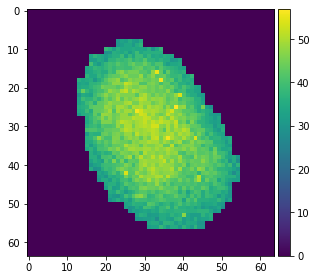

In [5]:
imshow(image_path)

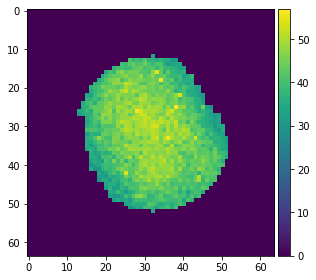

In [7]:
image_path = os.path.join(all_patches_dir, image_fn)
image = imread(image_path)
lx, ly = image.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx/2) ** 2 + (Y - ly/2) ** 2 > 20**2##lx * ly /10
# Masks
image[mask] = 0
imshow(image)

In [ ]:

all_patches_dir = '/home/nathan/data/kraken/pcna/glimpses/MK0000/non_edge_masked/'#'/home/nathan/data/confocal/pcna/glimpses/non_edge_32px'# os.path.join(glimpse_parent_folder, 'all')
files = [fn for fn in os.listdir(all_patches_dir) if '.tif' in fn]
output_dir = '/home/nathan/data/kraken/pcna/glimpses/MK0000/circle_20pxR'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for image_fn in tqdm(files):
    image_path = os.path.join(all_patches_dir, image_fn)
    image = imread(image_path)
    #shape = image.shape
    lx, ly = image.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx/2) ** 2 + (Y - ly/2) ** 2 > 20**2  ##lx * ly /10
    # Masks
    image[mask] = 0
    imsave(os.path.join(output_dir, image_fn), image) 

 38%|██████████████                       | 34420/90306 [08:45<16:46, 55.53it/s]

# organising output into one big folder indiscriminate of expt params

In [58]:
### collating files
files = []
glimpse_parent_folder = '/home/nathan/data/kraken/pcna/glimpses/MK0000'
pos_list = [pos for pos in os.listdir(glimpse_parent_folder) if 'Pos' in pos]
for pos in pos_list:
    pos_folder = os.path.join(glimpse_parent_folder, pos)
    channel_dirs = os.listdir(pos_folder)
    for channel in channel_dirs:
        channel_folder = os.path.join(pos_folder, channel)
        files.extend(glob.glob(os.path.join(channel_folder, '*.tif')))
    

In [59]:
### copying files
output_dir = os.path.join(glimpse_parent_folder, 'all')
Path(output_dir).mkdir(parents=True, exist_ok=True)
for i in tqdm(files):
    dest = os.path.join(output_dir, os.path.basename(i))
    shutil.copyfile(i, dest)

# Masking off the background

In [ ]:
masked_output_dir = os.path.join(glimpse_parent_folder, 'all_masked')
Path(masked_output_dir).mkdir(parents=True, exist_ok=True)
log = []
all_patches_dir = os.path.join(glimpse_parent_folder, 'all')
files = natsorted([fn for fn in os.listdir(all_patches_dir) if '.tif' in fn])
previous_tracks = []
for fn in tqdm(files):
    try:
        pos_name = re.findall("Pos\d", fn)[0]
        cell_ID = int(re.findall("cell_ID_(\d+)", fn)[0])

        print(pos_name, cell_ID)
        tracks_path_list = natsorted(glob.glob(os.path.join(expt_root_folder,'{}/{}/gfp*.h5'.format('MK0000',pos_name))))
        if len(tracks_path_list) > 0:
                tracks_path = tracks_path_list[-1]
        else:
            print(pos_name, cell_ID, 'couldnt load tracks')
            continue
        if tracks_path == previous_tracks:
            print(tracks_path, 'already loaded')
        else:
            with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_3") as hdf:
                wt_tracks = hdf.tracks
                print(tracks_path, 'loaded')
                previous_tracks = tracks_path

        ### load xyt, load mask, apply mask to image
        cell = [cell for cell in wt_tracks if cell.ID == cell_ID][0]
        time = int(re.findall("_t(\d+)", fn)[0])
        x, y = cell.x[cell.t.index(time)], cell.y[cell.t.index(time)]

        ### load mask 
        mask_dir = os.path.join(expt_root_folder,'{}/{}/{}_cp_masks'.format('MK0000',pos_name, pos_name))
        mask_fn = natsorted(os.listdir(mask_dir))[time]
        mask_image = imread(os.path.join(mask_dir, mask_fn))
        ### load corresponding image
        image = imread(os.path.join(all_patches_dir,fn))

        ### crop mask image
        size = int(glimpse_size[0])
        ### obtain coordinates of bounding box of glimpse (centered on cell)
        x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
        ### pad image incase cell goes off FOV
        mask_image_pad = np.pad(mask_image, int(size/2), 'constant', constant_values = 0) 
        ## cropping original image
        cropped_mask = mask_image_pad[int(y1): int(y2), int(x1): int(x2)]#[int(x1): int(x2), int(y1): int(y2)]
        ## finding pixel value of mask of interest
        pix_value = cropped_mask[int(size/2),int(size/2)]
        ### isolating mask of interest and assigning binary pix value
        true_mask = (cropped_mask == pix_value)*1
        ### applying mask to original glimpse
        true_glimpse = (true_mask*image).astype('uint16')
        ### save out
        imsave(os.path.join(masked_output_dir, fn), true_glimpse) 
    except Exception as err:
        message = str(err) + str(fn)
        print(message)
        log.append(message)

In [167]:
fn

In [165]:
imshow(mask_image)

In [177]:
x, y

In [166]:
mask_fn

In [140]:
size = int(glimpse_size[0])
### obtain coordinates of bounding box of glimpse (centered on cell)
x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
### pad image incase cell goes off FOV
mask_image_pad = np.pad(mask_image, int(size/2), 'constant', constant_values = 0) 
## glimpse creation by cropping original image
cropped_mask = mask_image_pad[int(y1): int(y2), int(x1): int(x2)]#transposed 

In [168]:
imshow(cropped_mask)

In [151]:
int(size/2)

In [170]:
pix_value = cropped_mask[int(size/2),int(size/2)]

In [171]:
pix_value

In [174]:
im_bool = (cropped_mask == pix_value)*1

In [175]:
imshow(im_bool)

In [179]:
os.path.join(all_patches_dir, fn)

In [181]:
image = imread(os.path.join(all_patches_dir, fn))

In [182]:
image*im_bool

In [190]:
imshow(true_glimpse)

In [ ]:
type(true_glimpse)

In [192]:
type(image)

In [189]:
imshow(image)

In [194]:
imread(os.path.join(masked_output_dir, 'Pos0_cell_ID_46_channel003_t0_age0.0.tif'))

In [126]:
cell

In [128]:
y

In [129]:
x1, x2, y1, y2

In [142]:
tracks_path